In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_envs_reward(enviroment):
    vetor_de_listas = [vec.episode_returns for vec in enviroment.envs]
    max_len = max(len(lista) for lista in vetor_de_listas)

    # Preencha as listas mais curtas com NaN para manter o comprimento
    vetor_preenchido = [lista + [np.nan] * (max_len - len(lista)) for lista in vetor_de_listas]

    # Converta para um array numpy para facilitar o manuseio
    array_preenchido = np.array(vetor_preenchido)

    # Calcule a média e o desvio padrão para cada ponto
    media = np.nanmean(array_preenchido, axis=0)
    desvio_padrao = np.nanstd(array_preenchido, axis=0)

    # Crie o gráfico
    x = np.arange(1, max_len + 1)
    plt.plot(x, media, label='Média')
    plt.fill_between(x, media - desvio_padrao, media + desvio_padrao, alpha=0.3, label='Desvio Padrão')

    plt.xlabel('Episódios')
    plt.ylabel('Recompensa média')
    plt.legend()
    plt.show()

In [2]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import StopTrainingOnMaxEpisodes

num_cpu = 8
env_id = "CartPole-v1"

search_env = make_vec_env(env_id, n_envs=num_cpu, vec_env_cls=DummyVecEnv)
vai_treinar_em_ep_sim = StopTrainingOnMaxEpisodes(max_episodes= 1000, verbose= 0)

# Se essa não for a prova definitiva da minha incompetência, eu n sei o que vai ser
hparams = {'learning_rate': 0.0023,
 'gamma': 0.99,
 'batch_size': 64,
 'buffer_size': 10000,
 'train_freq': 256,
 'target_update_interval': 10,
 'learning_starts': 1000,
 'gradient_steps': 128,
 'policy_kwargs': dict(net_arch = [256, 256]),
# 'max_grad_norm': 1,
 'exploration_initial_eps': 1,
 'exploration_final_eps': 0.04,
 'exploration_fraction': 0.16}

teste = DQN('MlpPolicy', search_env, verbose=0, **hparams)
teste.learn(total_timesteps=int(1e10), callback= vai_treinar_em_ep_sim, progress_bar=True)

eval_env = make_vec_env(env_id, n_envs=1, vec_env_cls=DummyVecEnv)
mean_reward, _ = evaluate_policy(teste, search_env, n_eval_episodes=1000 * 1, return_episode_rewards= True)

Output()

In [6]:
plot_envs_reward(eval_env)

AttributeError: 'list' object has no attribute 'envs'

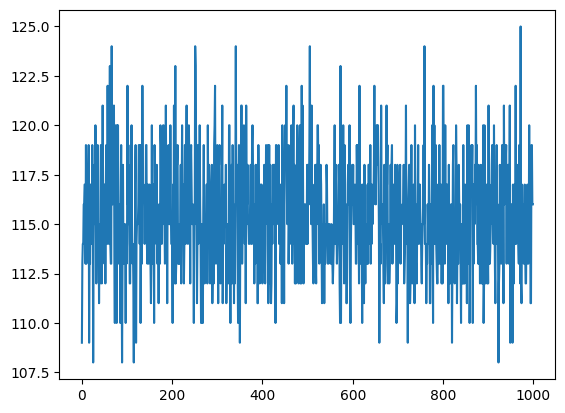

In [7]:
plt.plot(mean_reward)
plt.show()

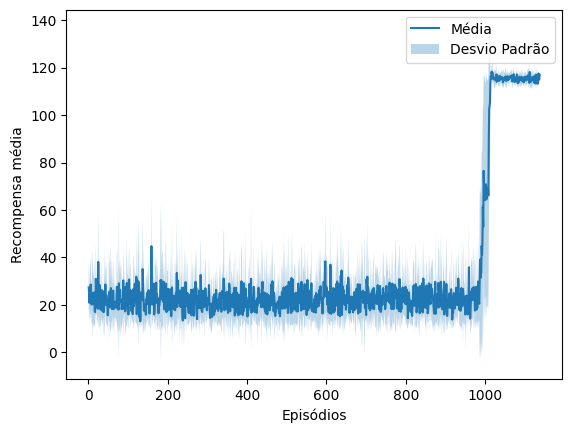

In [8]:
plot_envs_reward(search_env)

In [ ]:
plot_envs_reward(eval_env)

In [ ]:
import optuna
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

env_name = 'CartPole-v1'
search_env = Monitor(gym.make(env_name))#, render_mode = 'human'))

# Função de avaliação
def evaluate(trial):
    model_params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-3), #, log=True),
        'gamma': trial.suggest_categorical('gamma', [0.99]),
        #'batch_size': trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
        #'buffer_size': trial.suggest_categorical('buffer_size', [10000, 50000, 100000]),
        #'train_freq': trial.suggest_categorical('train_freq', [8, 16, 128, 256]),
        #'target_update_interval': trial.suggest_categorical('target_update_interval', [100]),
        'learning_starts': trial.suggest_categorical('learning_starts', [1000])
        #'gradient_steps': trial.suggest_categorical('gradient_steps', [1, 4, 8, 16, 32, 64, 128]),
        #'exploration_initial_eps': trial.suggest_float('exploration_initial_eps', 0.9, 1.0),
        #'exploration_final_eps': trial.suggest_float('exploration_final_eps', 0.0, 0.3),
        #'max_grad_norm': trial.suggest_categorical('max_grad_norm',[1.0, 10.0])
    }
    
    # Criação do modelo PPO
    model = DQN('MlpPolicy', search_env, verbose=0, **model_params)
    
    # Treinamento do modelo
    model.learn(total_timesteps=300)  # Ajuste o número de etapas conforme necessário

    # Avaliação do modelo
    mean_reward, _ = evaluate_policy(model, search_env, n_eval_episodes=1000)

    return mean_reward

class CheckHyperparamMeanRewardThreshold:
    def __init__(self, reward_threshold: float):
        self.reward_threshold = reward_threshold

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value is not None and trial.value >= self.reward_threshold:
            print((f'Stopping hyperparameter search because trial.value ({trial.value}) '
                   f'hit threshold ({self.reward_threshold})'))
            study.stop()


In [ ]:
import numpy as np
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Define o estudo Optuna
study = optuna.create_study(direction='maximize')
study.optimize(evaluate, n_trials = 10, callbacks=[CheckHyperparamMeanRewardThreshold(500.0)], show_progress_bar=True)

In [ ]:
# Obtém os melhores hiperparâmetros
best_model_params = {**study.best_params}

train_env = Monitor(gym.make(env_name))
# Criação do modelo com os melhores hiperparâmetros
best_model = DQN('MlpPolicy', train_env, **best_model_params)

# Treinamento do modelo final
best_model.learn(total_timesteps=int(1e5), log_interval=1, progress_bar=True)

eval_env = Monitor(gym.make(env_name))
_ = evaluate_policy(best_model, eval_env, n_eval_episodes=int(1e3), return_episode_rewards = False)

In [ ]:
import matplotlib.pyplot as plt
train_rewards = np.array(search_env.get_episode_rewards())
plt.plot(train_rewards)
plt.ylim(0, 550)
plt.show()

In [ ]:
train_rewards = np.array(train_env.get_episode_rewards())
plt.plot(train_rewards)
plt.ylim(0, 550)
plt.show()

In [ ]:
rewards = np.array(eval_env.get_episode_rewards())
plt.plot(rewards)
plt.ylim(0, 550)
plt.show()

In [ ]:
plt.hist(rewards)
plt.title('Histograma')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

In [ ]:
a = best_model.env.envs[0].episode_returns
recompensas = a
plt.plot(recompensas)
plt.show()